In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import asyncio

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, precision_score, roc_auc_score, recall_score, average_precision_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from matplotlib import pyplot as plt

from IPython.display import clear_output

In [3]:
y_train = pd.read_csv('../fraud_detection/active_datasets/y_train.csv', header=None).to_numpy().ravel()
y_test = pd.read_csv('../fraud_detection/active_datasets/y_test.csv', header=None).to_numpy().ravel()

In [4]:
df = pd.read_csv('./dataset_makers/original_data.csv')
df.replace("'",'', regex=True, inplace=True) 
df.drop(columns = ['step', 'age', 'gender', 'zipcodeOri', 'zipMerchant'], inplace=True)
train, test = train_test_split(df, random_state=42)
test.head()

,customer,merchant,category,amount,fraud
70803,C746862122,M348934600,es_transportation,11.65,0
470791,C1760492708,M1823072687,es_transportation,1.60,0
568310,C1984083185,M1823072687,es_transportation,33.36,0
23709,C1530262146,M1823072687,es_transportation,8.01,0
49723,C1471216995,M348934600,es_transportation,38.11,0


In [5]:
datasets = dict()
for bin_merchant in range(2, 6):
    c_cut_merchant = test.copy()
    q_cut_merchant = test.copy()

    c_merchant_fraud_rate = pd.cut(train.groupby('merchant').mean('fraud')['fraud'], bins = bin_merchant, labels=False)
    c_cut_merchant['merchant fraud rate'] = test['merchant'].apply(lambda x: c_merchant_fraud_rate.get(x))

    q_merchant_fraud_rate = pd.qcut(train.groupby('merchant').mean('fraud')['fraud'], bin_merchant, labels=False, duplicates='drop')
    q_cut_merchant['merchant fraud rate'] = test['merchant'].apply(lambda x: q_merchant_fraud_rate.get(x))
    for bin_customer in range(2, 6):
        c_cut_customer = c_cut_merchant.copy()
        q_cut_customer = q_cut_merchant.copy()
        c_customer_fraud_rate = pd.cut(train.groupby('customer').mean('fraud')['fraud'], bins = bin_customer, labels=False)
        c_cut_customer['customer fraud rate'] = test['customer'].apply(lambda x: c_customer_fraud_rate.get(x))

        q_customer_fraud_rate = pd.qcut(train.groupby('customer').mean('fraud')['fraud'], bin_customer, labels=False, duplicates='drop')
        q_cut_customer['customer fraud rate'] = test['customer'].apply(lambda x: q_customer_fraud_rate.get(x))
        for bin_category in range(2, 6):
            print(bin_merchant, bin_customer, bin_category)
            c_cut_category = c_cut_customer.copy()
            q_cut_category = q_cut_customer.copy()
            c_category_fraud_rate = pd.cut(train.groupby('category').mean('fraud')['fraud'], bins = bin_category, labels=False)
            c_cut_category['category fraud rate'] = test['category'].apply(lambda x: c_category_fraud_rate.get(x))

            q_category_fraud_rate = pd.qcut(train.groupby('category').mean('fraud')['fraud'], bin_category, labels=False, duplicates='drop')
            q_cut_category['category fraud rate'] = test['category'].apply(lambda x: q_category_fraud_rate.get(x))

            if c_cut_category.isna().sum().sum() > 0 or q_cut_category.isna().sum().sum() > 0:
                print('AHHHHHHHHHHHHHHHHHHHHH', c_cut_category.isna().sum().sum(), q_cut_category.isna().sum().sum())


            q_cut_category.drop(columns = ['merchant', 'customer', 'category'], inplace=True)
            c_cut_category.drop(columns = ['merchant', 'customer', 'category'], inplace=True)
            
            MMscaler = MinMaxScaler()
            q_cut_category = MMscaler.fit_transform(q_cut_category)
            c_cut_category = MMscaler.fit_transform(c_cut_category)

            datasets[('c', bin_merchant, bin_customer, bin_category)] = c_cut_category
            datasets[('q', bin_merchant, bin_customer, bin_category)] = q_cut_category



datasets.keys()

2 2 2
2 2 3
2 2 4
2 2 5
2 3 2
2 3 3
2 3 4
2 3 5
2 4 2
2 4 3
2 4 4
2 4 5
2 5 2
2 5 3
2 5 4
2 5 5
3 2 2
3 2 3
3 2 4
3 2 5
3 3 2
3 3 3
3 3 4
3 3 5
3 4 2
3 4 3
3 4 4
3 4 5
3 5 2
3 5 3
3 5 4
3 5 5
4 2 2
4 2 3
4 2 4
4 2 5
4 3 2
4 3 3
4 3 4
4 3 5
4 4 2
4 4 3
4 4 4
4 4 5
4 5 2
4 5 3
4 5 4
4 5 5
5 2 2
5 2 3
5 2 4
5 2 5
5 3 2
5 3 3
5 3 4
5 3 5
5 4 2
5 4 3
5 4 4
5 4 5
5 5 2
5 5 3
5 5 4
5 5 5


dict_keys([('c', 2, 2, 2), ('q', 2, 2, 2), ('c', 2, 2, 3), ('q', 2, 2, 3), ('c', 2, 2, 4), ('q', 2, 2, 4), ('c', 2, 2, 5), ('q', 2, 2, 5), ('c', 2, 3, 2), ('q', 2, 3, 2), ('c', 2, 3, 3), ('q', 2, 3, 3), ('c', 2, 3, 4), ('q', 2, 3, 4), ('c', 2, 3, 5), ('q', 2, 3, 5), ('c', 2, 4, 2), ('q', 2, 4, 2), ('c', 2, 4, 3), ('q', 2, 4, 3), ('c', 2, 4, 4), ('q', 2, 4, 4), ('c', 2, 4, 5), ('q', 2, 4, 5), ('c', 2, 5, 2), ('q', 2, 5, 2), ('c', 2, 5, 3), ('q', 2, 5, 3), ('c', 2, 5, 4), ('q', 2, 5, 4), ('c', 2, 5, 5), ('q', 2, 5, 5), ('c', 3, 2, 2), ('q', 3, 2, 2), ('c', 3, 2, 3), ('q', 3, 2, 3), ('c', 3, 2, 4), ('q', 3, 2, 4), ('c', 3, 2, 5), ('q', 3, 2, 5), ('c', 3, 3, 2), ('q', 3, 3, 2), ('c', 3, 3, 3), ('q', 3, 3, 3), ('c', 3, 3, 4), ('q', 3, 3, 4), ('c', 3, 3, 5), ('q', 3, 3, 5), ('c', 3, 4, 2), ('q', 3, 4, 2), ('c', 3, 4, 3), ('q', 3, 4, 3), ('c', 3, 4, 4), ('q', 3, 4, 4), ('c', 3, 4, 5), ('q', 3, 4, 5), ('c', 3, 5, 2), ('q', 3, 5, 2), ('c', 3, 5, 3), ('q', 3, 5, 3), ('c', 3, 5, 4), ('q', 3, 5, 4

In [6]:
def score(y_pred, y_true):
        scores = {}
        evaluation_funcs = {'accuracy':accuracy_score, 'precision':precision_score, 'recall':recall_score, 'f1':f1_score, 'MCC':matthews_corrcoef}
        for name, score in evaluation_funcs.items():
                scores[name] = score(y_pred = y_pred, y_true = y_true)
        scores['ROC-AUC'] = roc_auc_score(y_score = y_pred, y_true = y_true)
        scores['AUPR'] = average_precision_score(y_score = y_pred, y_true = y_true)

        return scores.values()

In [7]:
def build_lof(data, k):
    LOF = LocalOutlierFactor(n_neighbors = k, contamination=sum(y_train)/len(y_train))
    y_pred = LOF.fit_predict(data)
    y_pred = list(map(lambda x: {-1:1, 1:0}[x], y_pred))
    return list(score(y_pred=y_pred, y_true=y_test))
    

New scores: [0.979422982490364, 0.13979086406164007, 0.14514285714285713, 0.1424165965797589, 0.1320307374292095, 0.5672518813625742, 0.030352809254943176]
Current parameters. Dataset: ('q', 5, 5, 5). N_Neighbors: 500. Percent completed for current set: 100.0
Current Max Scores: [0.99029335 0.58447991 0.60685714 0.59545837 0.59065462 0.80085899
 0.35932379]


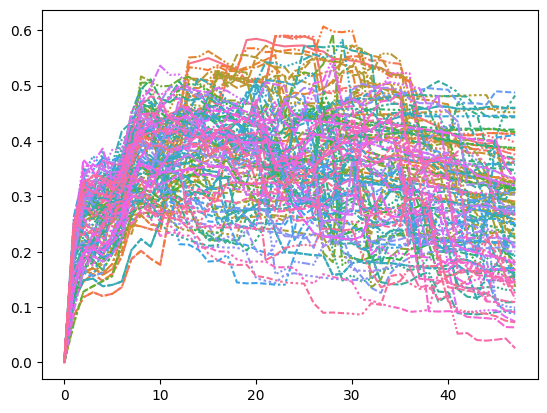

100%|██████████| 128/128 [42:27:14<00:00, 1194.02s/it]


In [10]:
scores = np.zeros((128, 48, 7))

for i, data_key in tqdm(enumerate(datasets.keys()), total=128):
    data = datasets[data_key]
    for j in range(30, 501, 10):
        new_scores = build_lof(data, j) 
        for k, s in enumerate(new_scores):
            scores[i,(j - 30)//10 , k] = s
    
    clear_output(True)   
    print(f'New scores: {new_scores}')
    print(f'Current parameters. Dataset: {data_key}. N_Neighbors: {j}. Percent completed for current set: {(j - 30)/4.7}')
    print(f'Current Max Scores: {np.max(np.max(scores, 0), 0)}')
    recall_values = scores[:, :, 2].T
    sns.lineplot(recall_values, legend=False)
    plt.show()

    

In [12]:
np.save('nneighbor_runs', scores)

In [21]:
keys = list(datasets.keys())

In [39]:
np.argmax(scores[:, :, 6].max(axis=0), axis = 0)

27

In [43]:
keys[8]

('c', 2, 3, 2)

In [46]:
scores[8, 27, :]

array([0.99029335, 0.58447991, 0.60685714, 0.59545837, 0.59065462,
       0.80085899, 0.35932379])

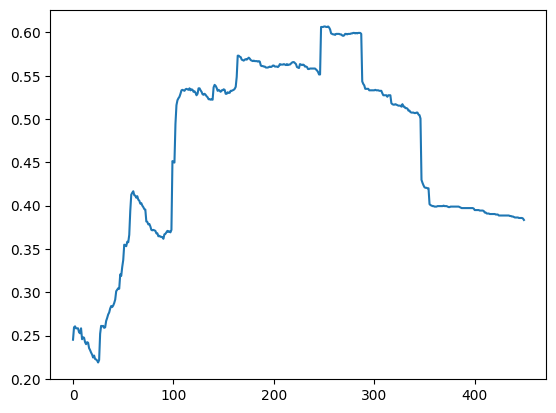

100%|██████████| 450/450 [3:28:29<00:00, 27.80s/it]


In [47]:
best_data = datasets[('c', 2, 3, 2)]
best_scores = []
for k in tqdm(range(50, 500)):
    best_scores.append(build_lof(best_data, k))
    clear_output(True)
    recall_values = [x[2] for x in best_scores]
    sns.lineplot(recall_values, legend=False)
    plt.show()
    

In [75]:
for i in range(7):
    scores = [x[i] for x in best_scores]
    print(np.argmax(scores), np.max(scores))

255 0.9903135321301485
255 0.585635359116022
250 0.6068571428571429
254 0.5957924263674614
254 0.5909893013467634
254 0.8008657953260332
254 0.3597146378891232
